<a href="https://colab.research.google.com/github/ac1147/Lifting_Tracker/blob/main/Workout_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

In [7]:
!pip install gspread gspread_dataframe

# Authenticate with your Google account
from google.colab import auth
auth.authenticate_user()

import gspread
from gspread_dataframe import get_as_dataframe
from google.auth import default
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Authorize access to Google Sheets
creds, _ = default()
gc = gspread.authorize(creds)

# **Set Up Data**

In [8]:
# Open the spreadsheet by its name
sh = gc.open("Lifting Progress")

# Select the sheet (tab) called "Master Data Base"
worksheet = sh.worksheet("Matser Data Base")

# Convert the sheet into a pandas DataFrame
df = get_as_dataframe(worksheet, evaluate_formulas=True, dtype=str)

# Drop completely empty rows/columns (common in Sheets)
df = df.dropna(how="all").reset_index(drop=True)

# Convert columns to proper dtypes
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df["Sets"] = pd.to_numeric(df["Sets"], errors="coerce")
df["Weight"] = pd.to_numeric(df["Weight"], errors="coerce")
df["Reps"] = pd.to_numeric(df["Reps"], errors="coerce")
df["Days"] = (df["Date"] - df["Date"].min()).dt.days

#Add 1RM Column using brzycki formula
df["1RM"] = df["Weight"] / (1.0278 - (0.0278 * df["Reps"]))

#Add set volume
df["Set Volume"] = df["Weight"] * df["Reps"]

#Add Total Volume
for index in range(2, len(df), 4):
  df.loc[index, "Total Volume"] = df.loc[index - 2, "Set Volume"] + df.loc[index - 1, "Set Volume"] + df.loc[index, "Set Volume"] + df.loc[index + 1, "Set Volume"]

#Display preview
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)
print(df.head(8))

        Date       Exercise  Sets  Weight  Reps  Days         1RM  Set Volume  Total Volume
0 2025-08-30  Lat Pull Down     1    80.0  12.0     0  115.240565       960.0           NaN
1 2025-08-30  Lat Pull Down     2   115.0   7.5     0  140.363725       862.5           NaN
2 2025-08-30  Lat Pull Down     3   115.0   5.0     0  129.387939       575.0        3072.5
3 2025-08-30  Lat Pull Down     4    75.0   9.0     0   96.450617       675.0           NaN
4 2025-08-30     Seated Row     1    85.0  12.0     0  122.443100      1020.0           NaN
5 2025-08-30     Seated Row     2    95.0  10.0     0  126.700453       950.0           NaN
6 2025-08-30     Seated Row     3   105.0   7.0     0  126.020163       735.0        3305.0
7 2025-08-30     Seated Row     4    75.0   8.0     0   93.121430       600.0           NaN


# **Plot Data**

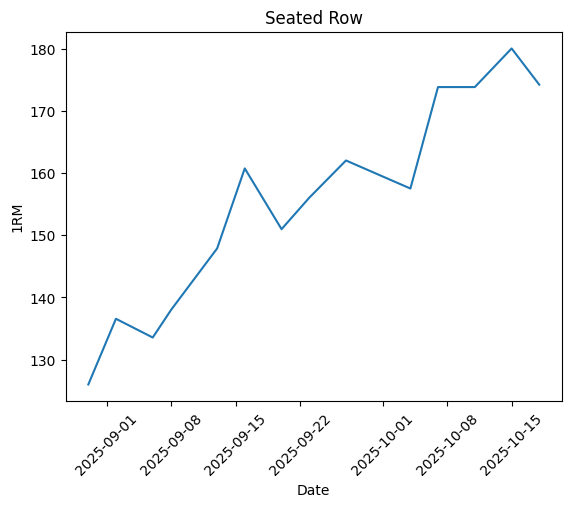

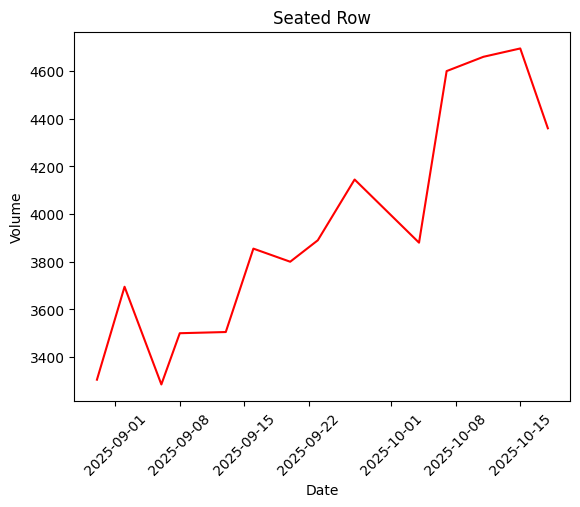

In [9]:
def plotOneRepMax(Exercise):
    #Function to make line plot of One Rep Max vs Time for an exercise

    exerciseData = df[df["Exercise"] == Exercise]
    exerciseDataThree = exerciseData[exerciseData["Sets"] == 3]

    plt.plot(exerciseDataThree["Date"], exerciseDataThree["1RM"])
    plt.xlabel("Date")
    plt.xticks(rotation=45)  # or 90 for vertical
    plt.ylabel("1RM")
    plt.title(Exercise)
    plt.show()
    return

def plotVol(Exercise):
    #Function to make line plot of One Rep Max vs Time for an exercise

    exerciseData = df[df["Exercise"] == Exercise]
    exerciseDataThree = exerciseData[exerciseData["Sets"] == 3]

    plt.plot(exerciseDataThree["Date"], exerciseDataThree["Total Volume"], color = 'red')
    plt.xlabel("Date")
    plt.xticks(rotation=45)  # or 90 for vertical
    plt.ylabel("Volume")
    plt.title(Exercise)
    plt.show()
    return

plotOneRepMax("Seated Row")
plotVol("Seated Row")

# **Show Stats**

In [10]:
def findCorrelation(Exercise):
    #Function that finds spearman correlation coefficent between 1RM and Time

    exerciseData = df[df["Exercise"] == Exercise]
    exerciseDataThree = exerciseData[exerciseData["Sets"] == 3]

    oneRepMax = exerciseDataThree["Weight"] / (1.0278 - ( 0.0278 * exerciseDataThree["Reps"]))

    corr, _ = spearmanr(exerciseDataThree["Days"], oneRepMax)
    return corr

def findPValue(Exercise):
    #Function that finds spearman correlation coefficent between 1RM and Time

    exerciseData = df[df["Exercise"] == Exercise]
    exerciseDataThree = exerciseData[exerciseData["Sets"] == 3]

    oneRepMax = exerciseDataThree["Weight"] / (1.0278 - (0.0278 * exerciseDataThree["Reps"]))

    _, pValue = spearmanr(exerciseDataThree["Days"], oneRepMax)
    return pValue


exerciseList = df["Exercise"].unique().tolist()


def avgPercentIncrease(Exercise):
    exerciseData = df[df["Exercise"] == Exercise]
    exerciseDataThree = exerciseData[exerciseData["Sets"] == 3]
    exerciseDataThree = exerciseDataThree.reset_index(drop=True)

    totalPercentIncrease = 0

    for index in range(1, len(exerciseDataThree)):
      percentInc = exerciseDataThree.loc[index, "1RM"]/exerciseDataThree.loc[index-1, "1RM"] * 100 - 100
      totalPercentIncrease += percentInc

    avgPercentInc = totalPercentIncrease / (len(exerciseDataThree) - 1)
    return avgPercentInc

def diff1RM(Exercise):
    exerciseData = df[df["Exercise"] == Exercise]
    exerciseDataThree = exerciseData[exerciseData["Sets"] == 3]
    exerciseDataThree = exerciseDataThree.reset_index(drop=True)

    min_index = exerciseDataThree["Days"].idxmin()
    max_index = exerciseDataThree["Days"].idxmax()
    min_1RM = exerciseDataThree.loc[min_index, "1RM"]
    max_1RM = exerciseDataThree.loc[max_index, "1RM"]

    return max_1RM - min_1RM




# Make new data frame with spearman correlation and P Values
corrValues = {
    'Exercise': exerciseList,
    'Corr': [findCorrelation(exercise) for exercise in exerciseList],
    'pValue': [findPValue(exercise) for exercise in exerciseList],
    'Avg % Inc': [avgPercentIncrease(exercise) for exercise in exerciseList],
    '1RM diff': [diff1RM(exercise) for exercise in exerciseList]
}

exerciseStats = pd.DataFrame(corrValues)

exerciseStats_sorted = exerciseStats.sort_values(by = 'Corr', ascending = True)
exerciseStats_sorted = exerciseStats_sorted.reset_index(drop=True)

print(exerciseStats_sorted)



                 Exercise      Corr        pValue  Avg % Inc   1RM diff
0     Baysian Cable Curls  0.169472  5.624538e-01   0.870712   2.225443
1    Tricpe Overhead Rope  0.555358  3.161847e-02   1.068886   4.243291
2    Tricep Rope Pushdown  0.887700  1.004353e-05   2.555046  13.452327
3           Incline Press  0.891464  8.122855e-06   1.769274  10.868358
4          Shoulder Press  0.920751  1.130917e-06   1.988555  13.546757
5             Fly Machine  0.933810  3.622655e-07   3.811548  66.010562
6           Lat Pull Down  0.941451  5.122637e-07   2.499297  47.592410
7              Seated Row  0.954896  1.102624e-07   2.644186  48.195865
8    Cable Lateral Raises  0.965868  5.288317e-09   5.976980   6.836023
9   Preacher Curl Machine  0.981230  6.062945e-10   3.488517  41.584621
10      Rear Delt Machine  0.988960  2.552986e-11   3.662943  45.404031
11             Ab Machine  1.000000  0.000000e+00   8.147167  16.181957
